## `Занятие 1.2: Основы Pytorch`
#### `Сириус, смена "Алгоритмы и анализ данных" 2024`

#### `Первое ключевое отличие — возможность перемещения на GPU`

In [10]:
a = torch.randn(3, 5)
a.dtype, a.device

(torch.float32, device(type='cpu'))

Проверим, что GPU доступна:

In [11]:
torch.cuda.is_available()

False

In [12]:
device = (
    torch.device('cuda', 0) # эквивалентно: torch.device('cuda:0') / 'cuda' / 'cuda:0'
    if torch.cuda.is_available() 
    else torch.device('cpu') 
)
device

device(type='cpu')

In [13]:
a.to(device)

tensor([[ 0.1152,  0.1546, -0.9449, -1.6251, -0.8447],
        [-0.5225, -1.1298, -1.2684,  1.1318,  0.0315],
        [ 0.2922, -1.4419,  0.7172,  1.2302, -0.3422]])

Операции между тензорами на разных устройствах не возможны:

In [ ]:
a.cuda() + a

Обратите внимание, что при изменении device (c GPU на CPU и обратно происходит копирование):

In [ ]:
p_cpu = torch.rand(10)
p_gpu = p_cpu.to(device)

p_cpu -= 1
p_cpu, p_gpu

#### `Второе ключевое отличие — Autograd`

Все тензоры содержат атрибут `.grad`, который может хранить градиент по этому тензору.

In [14]:
a.grad

По умолчанию, тензоры, создаваемые в pytorch, не будут требовать, чтобы для них посчитали градиент. Для этого надо добавить дополнительный аргумент `requires_grad=True`, либо вызвав метод `.requires_grad_()`.

In [15]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = torch.tensor([1., 2., 3.])
y.requires_grad_()

tensor([1., 2., 3.], requires_grad=True)

Производя операции с переменными, по которым нужно считать градиенты, мы конструируем граф вычислений:

In [16]:
z = 3 * x**3 - y**2
z.requires_grad

True

В каждой переменной есть информация о том, как именно она была получена при проходе вперёд. Исходя из этой информации у тензоров в графе вычислений хранятся функции, которые должны быть вызваны на обратном проходе для расчёта градиента.

In [17]:
z.grad_fn

Считать для каждого тензора якобиан целиком — сильно неоптимально. Вместо этого на всех промежуточных этапах autograd считает только произведения якобиан-вектор. В частности из-за этого, конечный тензор в графе всегда должен быть скаляром, что выполняется для всех функций потерь по определению.

Для примера сделаем из тензора `z` скаляр, сложив все его элементы, и посчитаем градиенты с помощью функции .backward()

In [18]:
z.sum().backward()

In [19]:
x.grad, y.grad

(tensor([ 9., 36., 81.]), tensor([-2., -4., -6.]))

Сравним с посчитанным вручную градиентом:

In [20]:
torch.allclose(x.grad, 9 * x**2)

True

Однако, для оптимизации вычислений, градиенты не вычисляются в явном виде для промежуточных вершин графа

In [21]:
z.grad

/var/folders/3c/vr2463p11lz5fr_80mrg72gh0000gq/T/ipykernel_47876/4110045842.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:485.)
  z.grad


Если такое всё же нужно, требуется указать это явно с помощью вызова `.retain_grad()`

In [22]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = torch.tensor([1., 2., 3.])

z = 3 * x**3 - y**2
z.retain_grad()

z.sum().backward()
z.grad

tensor([1., 1., 1.])

#### `Визуализация графа вычислений`

Для примера визуализируем, как бы выглядел граф вычислений для линейной регресси.

Заметим, что пакет визуализации `pytorchviz` предназначен в первую очередь для визуализации нейронных сетей, поэтому нам необходимо будет использовать класс `torch.nn.Parameter`, который является обёрткой над тензором и несколько расширяет возможности аргумента `requires_grad=True`

Графы визуализируются библиотекой `graphviz`. 

In [23]:
! pip3 install torchviz


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [24]:
from torchviz import make_dot

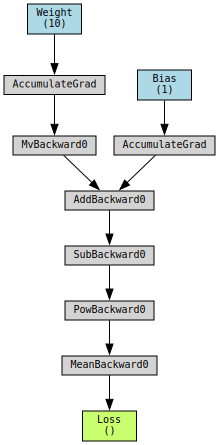

In [25]:
X = torch.rand(5, 10)
y = torch.rand(5)

w = torch.nn.Parameter(torch.rand(10))
b = torch.nn.Parameter(torch.rand(1))

y_hat = X @ w + b

loss = torch.mean((y - y_hat)**2)
make_dot(loss, params={'Weight': w, 'Bias': b, 'Loss': loss})

Что можно сказать об этом графе вычислений?

* В листьях графа мы не видим тензора `X`, так кка нам требуется расчёт градиента только по параметрам модели.
* `MvBackward0` соответствует матрично-векторному умножению (отсюда и первые буквы `Mv`) c матрицей `X`.
* `AddBackward0` соответствует добавлению смещения `b`, остальная часть графа — вычисление MSE.

#### `Аккумулирование градиентов`

Если не предпринимать никаких дополнительных действий, то множественный вызов `.backward()` будет не перезаписывать градиенты тензоров, а складывать их с уже существующим значением (сам граф вычислений каждый раз разрушается). Такое поведение может быть, например, нужно, чтобы посчитать градиент по батчу данных, который не влезает в память компьютера целиком, так как градиент модели аддитивен по входным данным.

In [26]:
x = torch.randn(3, 3, requires_grad=True)
y = torch.sum(x * x)
y.backward()

x.grad

tensor([[ 1.6422, -1.6038,  1.4735],
        [ 0.8832, -1.2830, -0.0582],
        [-2.3583, -0.6569,  1.2666]])

In [27]:
z = torch.sum(2 * x)
z.backward()

# Заметьте, что ко всем значениям прибавилось 2
x.grad

tensor([[ 3.6422,  0.3962,  3.4735],
        [ 2.8832,  0.7170,  1.9418],
        [-0.3583,  1.3431,  3.2666]])

Также подобный подход используется в рекуррентных нейронных сетях, где к одному и тому же тензору весов нейросети происходит несколько обращений во время прямого прохода.

Чтобы считать градиент с нуля, достаточно удалить тензор.

In [28]:
x.grad = None

#### `Inplace операции`

По умолчанию, вызов `y = 2 * x` создаст новый тензор, в который скопирует значения `x`, умноженные на `2`. И есть большое желание провести данную операцию на месте, то есть без аллокации памяти. В nupmy это не имело бы никаких дополнительных последствий, но в pytorch нам надо помнить о графе вычислений, который должен быть без петель, а также может использовать тензоры, рассчитанные при прямом вычислении. В некоторых случаях библиотека может выполнить код и не ругнуться, но описание ситуаций, когда такое сработает, а когда нет, очень сложно, и потому сами разработчики не рекомендуют использовать in-place операции там, где необходим расчёт градиента.

In-place операции всегда имеют символ `_` на конце.

In [29]:
x = torch.randn(3, 3, requires_grad=True)
y = 2 * x
z = y ** 2
# inplace operation!
y.exp_()  
z.sum().backward()

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [3, 3]], which is output 0 of ExpBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

Другой распространённый в numpy сценарий - маскированное изменение значений тензора. Это тоже является in-place операцией. В pytorch для этого лучше использовать функцию `torch.where`:

In [30]:
x = torch.rand(3,3, requires_grad=True)
x

tensor([[0.4336, 0.4062, 0.5464],
        [0.6937, 0.9116, 0.0409],
        [0.7574, 0.9459, 0.3376]], requires_grad=True)

In [31]:
x[x > 0.5] = 0

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

In [32]:
torch.where(x > 0.5, 0, x)

tensor([[0.4336, 0.4062, 0.0000],
        [0.0000, 0.0000, 0.0409],
        [0.0000, 0.0000, 0.3376]], grad_fn=<WhereBackward0>)

#### `Копирование тензоров`

В numpy существует интуитивно понятная функция `.copy()`, но в pytorch функции с таким названием нет! Это связано с тем, что тензоры в pytorch привязаны к графу вычислений, который надо также учитывать при копировании.

`.clone()` копирует тензор и сохраняет его привязку к текущему дереву вычислений:

In [33]:
x = torch.rand(3, requires_grad=True)
y = x.clone()
y.requires_grad

True

`.detach()` исходя из своего названия, копирует лишь значения элементов тензора, отвязывая его от текущего графа вычислений:

In [34]:
y = x.detach()
y.requires_grad

False

Продемонстрируем на графе вычислений эти две операции:

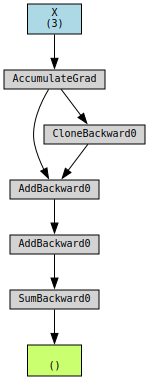

In [35]:
x = torch.nn.Parameter(torch.rand(3))
y = torch.nn.Parameter(torch.rand(3))

z = torch.sum(x + x.clone() + y.detach())

make_dot(z, params={'X': x, 'Y': y})

Что можно понять из данного графа?

* Видна операция `CloneBackward0`, которая клонирует тензор `x`. Благодаря ей в сумме участвует как исходный тензор, так и его экспонированная версия.
* Во второй сумме мы не видим параметра `y`, потому что он входит в граф вычислений только через `.detach()`, что убирает проход градиентов.

#### `Менеджеры контекста`

Поведением градиента сразу группы тензоров можно управлять с помощью специальных функций, которые вызываются через стандартную семантику питона `with foo():`, где `foo` — одна из трёх функций ниже:

**Default Mode**

Стандартный режим работы pytorch, в котором управление градиентами происходит через requires_grad. Явно его нужно вызывать только внутри других контекстных менеджеров, чтобы временно снова активировать расчёт градиентов (что случается крайне редко) вызовом `torch.enable_grad()`.

**No grad mode**

Данный режим используется когда блока кода нет необходимости вычислять градиенты, что занимает как вычислительные ресурсы, так и дополнительную память. Реализуется вызовом `torch.no_grad()`.

**Inference mode**

Аналогично No grad mode отключает расчёт градиентов, но кроме того проводит дополнительные оптимизации, что делает вычисления внутри блока кода ещё быстрее. Однако, тензоры, созданные в таком блоке будет невозможно использовать совместно с тензорами, для которых расчёт градиента необходим. Реализуется вызовом `torch.inference_mode()`.

In [42]:
x = torch.rand(3, requires_grad=True)

with torch.no_grad():
    y = x + x
    
y.requires_grad

False

In [43]:
@torch.no_grad()
def foo(x):
    return x + 2

y = foo(x)
y.requires_grad

False

#### `.item`

Часто при подсчёте метрик возникают тензоры из одного элемента/скаляры, которые могут находится на GPU или быть частью графа вычислений.

Сохранение таких тензоров в массив приведёт к утечке памяти. Чтобы этого избежать существует возможность трансформирования таких тензоров в Python скаляр:

In [44]:
x = torch.randn(10, requires_grad=True)
loss = torch.mean(x, dim=0, keepdim=True)
loss, loss.item()

(tensor([-0.2333], grad_fn=<MeanBackward1>), -0.23329778015613556)